# s1 backscatter for lake ice cover

In [2]:
# run this on planeatry computer [conda env: notebook]*
from dask.distributed import LocalCluster
import dask
import dask.dataframe as dd
import geopandas as gpd
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pystac
import pystac_client
import planetary_computer
import rioxarray as rio
import seaborn as sns
from shapely.geometry import LineString, Point, box, Polygon
import stackstac
from tqdm import tqdm
import xarray as xr
import utils
from geocube.api.core import make_geocube

import sarsen
import adlfs
import requests

In [3]:
centrelines = gpd.read_file('../data/streams_v3.geojson')

basins = (gpd.read_file('../data/basins/Greenland_Basins_PS_v1.4.2.shp')
          .dissolve('SUBREGION1'))
centrelines = centrelines.sjoin(basins.drop(columns=['NAME', 'GL_TYPE']),
                                how='left'
                                ).rename(columns={'index_right': 'region'})

lakes = gpd.read_file('../data/lake_areas.geojson')

lakes = lakes.sjoin_nearest(centrelines)
lakes = lakes.sort_values(by='id').drop(columns=['index_right', 'name', 'lake_land'])

In [4]:
# doesn't need running again because saved output to: '../results/s1_lake_backscatter.parquet'
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
medians = []
ids = []
for row in tqdm(lakes.to_crs(4326).sample(1).itertuples()):
    
    search = catalog.search(collections=['sentinel-1-rtc'],
                            intersects=row.geometry)
    
    s1items = search.item_collection()
    
    # get most common projection
    vals, cnts = np.unique([item.properties['proj:epsg'] for item in s1items] ,return_counts=True)
    epsg = int(vals[np.argmax(cnts)])
    
    # stack & clip
    ds = stackstac.stack(planetary_computer.sign(s1items),
                        epsg=epsg,
                        bounds_latlon=row.geometry.bounds)
    
    mask = (make_geocube(lakes.to_crs(4326).loc[lakes['id']==row.id],
                          fill=np.nan,
                          like=ds)['id']
             .rename('mask'))
    
    # apply mask and convert to dB
    ds_db = xr.where(mask==row.id,
                     10 * np.log10(ds),
                     np.nan)

    median = (ds_db
              .median(dim=['y','x'], skipna=True)
              .rename('dB'))
    
    medians.append(median) # consider making this a future
    ids.append(row.id)


1it [00:05,  5.39s/it]


## wip: getting local incidence angle across sar image

using: 
- https://github.com/egagli/generate_sentinel1_local_incidence_angle_maps/blob/882b9940a843c6dc3040f992ad6bed14201a2f5c/generate_lia.py#L61
- https://github.com/microsoft/PlanetaryComputerExamples/blob/main/tutorials/rtc-qualitative-assessment.ipynb
- and sarsen

In [5]:
# get a dem
def get_copernicus_dem(geom: Polygon,
                        res: int = 30,
                        ):
    '''
    get Copernicus Global DEM from planetary computer stac catalog
    inputs:
        geom - shapely geometry (polygon / box)
        res - int: resolution of DEM (either 30, or 90, default 30)
        rprj - bool: whether or not to reprojct the dem
        prj - projection to reprject to
        interp - whether or not to interpolate nans
    returns: xarray instance of DEM
    clipped to envelope of `geom`
    if reprojected then not only clipped but also aligned
    with nan's interpolated
    '''

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )

    search = catalog.search(collections=[f'cop-dem-glo-{res}'],
                            intersects=geom.envelope)

    items = search.item_collection()
    if len(items) > 0:
        dem = (stackstac.stack(
            planetary_computer.sign(items))
            .mean(dim='time', skipna=True)
            .squeeze()
            .rio.write_crs(4326)
            .rio.clip_box(*geom.bounds)
            )
        
    return dem


In [6]:
dem = get_copernicus_dem(row.geometry)
demprj = dem.rio.reproject_match(ds, nodata=np.nan)

In [7]:
bucket = "s1-grd"
token = planetary_computer.sas.get_token('sentinel1euwest', 's1-grd').token
grd_fs = adlfs.AzureBlobFileSystem('sentinel1euwest', credential=token)

In [ ]:
# unique relative orbits
unique_relative_orbits = np.unique(ds['sat:relative_orbit'])
ids = []
for orb in unique_relative_orbits:
    file_id = ds[ds['sat:relative_orbit']==orb][0].id.values
    rtc_item = catalog.get_collection('sentinel-1-rtc').get_item(file_id)
    grd_item = pystac.read_file(rtc_item.get_single_link("derived_from").target)
    
    grd_band = [grd_item.assets.get(band, None)
                for band in ['hh', 'hv', 'vh', 'vv']
                if band in grd_item.assets.keys()][0]

    ids.append(grd_band.href[53:-23])

['s1-grd/GRD/2025/2/15/IW/DH/S1A_IW_GRDH_1SDH_20250215T204541_20250215T204606_057912_072525_8BB2/annotation',
 's1-grd/GRD/2025/2/15/IW/DH/S1A_IW_GRDH_1SDH_20250215T204541_20250215T204606_057912_072525_8BB2/manifest.safe',
 's1-grd/GRD/2025/2/15/IW/DH/S1A_IW_GRDH_1SDH_20250215T204541_20250215T204606_057912_072525_8BB2/measurement',
 's1-grd/GRD/2025/2/15/IW/DH/S1A_IW_GRDH_1SDH_20250215T204541_20250215T204606_057912_072525_8BB2/preview',
 's1-grd/GRD/2025/2/15/IW/DH/S1A_IW_GRDH_1SDH_20250215T204541_20250215T204606_057912_072525_8BB2/productInfo.json',
 's1-grd/GRD/2025/2/15/IW/DH/S1A_IW_GRDH_1SDH_20250215T204541_20250215T204606_057912_072525_8BB2/report-20250215T231943.pdf',
 's1-grd/GRD/2025/2/15/IW/DH/S1A_IW_GRDH_1SDH_20250215T204541_20250215T204606_057912_072525_8BB2/support']

In [34]:
import os
def mirror_folder(fs, bucket, folder, exclude="vh"):
    # from https://github.com/bopen/sarsen/blob/main/notebooks/gamma_wrt_incidence_angle-S1-GRD-IW-RTC-South-of-Redmond.ipynb
    for path, folders, files in fs.walk(f"{bucket}/{folder}"):
        os.makedirs(path[len(bucket) + 1 :], exist_ok=True)
        for f in files:
            if exclude in f:
                continue
            file_path = os.path.join(path, f)
            lfile_path = file_path[len(bucket) + 1 :]
            if not os.path.isfile(lfile_path):
                fs.download(file_path, lfile_path + "~")
                os.rename(lfile_path + "~", lfile_path)

'IW/HH/coordinate_conversion'

In [130]:
mirror_folder(grd_fs, bucket, ids[0])
sarsen.sentinel1.open_dataset_autodetect(ids[0])[0].attrs['subgroups'] #, group='IW/HH')
orbit_ecef, _ = sarsen.sentinel1.open_dataset_autodetect(ids[0], group='IW/HH/orbit')

coord_conv = [grp for grp in sarsen.sentinel1.open_dataset_autodetect(ids[0])[0].attrs['subgroups'] if 'coordinate_conversion' in grp][0]
coord_conversion, _ = sarsen.sentinel1.open_dataset_autodetect(ids[0], group=coord_conv)

/home/s1759665/micromamba/envs/pro/lib/python3.12/site-packages/sarsen/sentinel1.py:34: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = xr.open_dataset(product_urlpath, group=group, chunks=chunks, **kwargs)
/home/s1759665/micromamba/envs/pro/lib/python3.12/site-packages/sarsen/sentinel1.py:34: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np

In [ ]:
dem_prj = demprj.drop_vars(['epsg',
                            'proj:transform',
                            'proj:epsg',
                            'proj:shape']).rio.write_crs(demprj.rio.crs)
if dem_prj.y.diff('y').values[0] < 0:
    dem_prj = dem_prj.isel(y=slice(None, None, -1))
dem_prj.attrs['long_name'] = 'elevation'
dem_prj.attrs['units'] = 'm'
dem_prj = dem_prj.rename('dem').squeeze(drop=True)

dem_ecef = sarsen.scene.convert_to_dem_ecef(dem_prj,
                                            source_crs=demprj.rio.crs)

In [131]:
def slant_to_ground(a, b):
    xarray_sentinel.slant_range_time_to_ground_range(a, b, coordinate_conversion=coord_conversion)

In [132]:
acquisition = sarsen.apps.simulate_acquisition(dem_ecef,
                                               orbit_ecef.position,
                                               slant_range_time_to_ground_range=slant_to_ground,
                                               correct_radiometry=True)
oriented_area = sarsen.scene.compute_dem_oriented_area(dem_ecef)
dem_normal = -oriented_area / np.sqrt(xr.dot(oriented_area, oriented_area, dims="axis"))
orbit_interpolator = sarsen.orbit.OrbitPolyfitIterpolator.from_position(orbit_ecef.position)
position_ecef = orbit_interpolator.position()
velocity_ecef = orbit_interpolator.velocity()
acquisition = sarsen.geocoding.backward_geocode(dem_ecef, orbit_ecef.position, velocity_ecef)
slant_range = np.sqrt((acquisition.dem_distance**2).sum(dim="axis"))
dem_direction = acquisition.dem_distance / slant_range
angle = np.arccos(xr.dot(dem_normal, dem_direction, dims="axis"))

/home/s1759665/micromamba/envs/pro/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/s1759665/micromamba/envs/pro/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/s1759665/micromamba/envs/pro/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/s1759665/micromamba/envs/pro/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/home/s1759665/micromamba/envs/pro/lib/python3.12/site-packages/numpy/core/numeric.py:1655: RuntimeWarning: invalid value encountered in subtract
  cp2 -= tmp
/home/s1759665/micromamba/

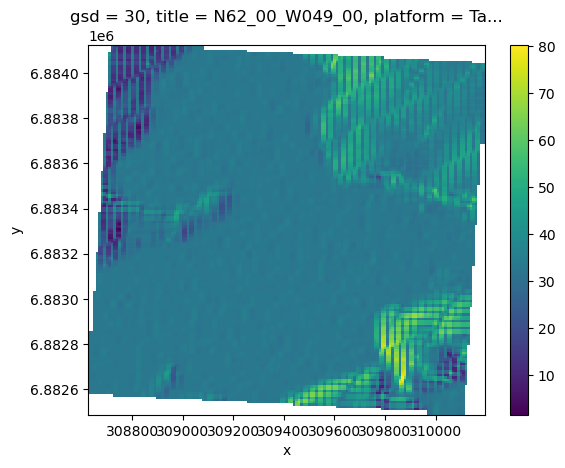

In [135]:
np.degrees(angle).plot()

## get s1 data

In [ ]:

with LocalCluster() as cluster:
    client = cluster.get_client()
    print(client.dashboard_link)    
    computed_medians = dask.compute(*medians)
    dfs = []
    for m_ds, id in zip(computed_medians, ids):
        _df = m_ds.to_dataframe()
        _df['myid'] = id
        dfs.append(_df)
    
    df = pd.concat(dfs).reset_index().set_index('time')
    
df.to_parquet('../results/s1_lake_backscatter.parquet')

In [ ]:
df = pd.read_parquet('../results/s1_lake_backscatter.parquet')
df = df.merge(centrelines['SUBREGION1'], left_on='myid', right_index=True)

In [ ]:
df.head()

In [ ]:
df

In [ ]:
site = 1
pol = 'hh'

fig, ax = plt.subplots(figsize=[15,8])
df.loc[(df['myid']==site) & (df['band']==pol)]['dB'].rolling('30d', center=True).median().plot(ax=ax)

In [ ]:
fg = sns.relplot(data=df.groupby(['myid', 'band', 'SUBREGION1'])['dB'].rolling('30d').median().reset_index(),
                 x='time',
                 y='dB',
                 row='SUBREGION1',
                 hue='SUBREGION1',
                 style='myid',
                 palette='tab10',
                 col='band',
                 col_order=['hh'],
                 kind='line',
                 aspect=2,
                #  height=10
                 )

fg.set(ylim=(-22,2))

In [ ]:
df['doy'] = df.index.day_of_year
df['year'] = df.index.year

In [ ]:
smoothed = df.groupby(['myid', 'band', 'SUBREGION1'])['dB'].rolling('30d', min_periods=3, center=True).median().reset_index()
smoothed['doy'] = smoothed['time'].dt.day_of_year
smoothed['year'] = smoothed['time'].dt.year


In [ ]:
sns.relplot(data=smoothed.loc[
    (smoothed['band'].isin(['hh']))
    & (smoothed['year'].isin([2018, 2024]))
    ],
            x='doy',
            y='dB',
            hue='year',
            col='SUBREGION1',
            col_wrap=3,
            # row='SUBREGION1',
            kind='line')